In [2]:
from matplotlib import pyplot as plt
import matplotlib

import uproot as urt

import numpy as np

import awkward as ak

import h5py

def exportTree(final_dataset,treeNameToExport,export_filename): 
    export_file = urt.recreate(export_filename)
    print("\n\t  file exported  : ",export_filename)
    allBranchesToWrite={ ky : final_dataset[ky].dtype for ky in final_dataset}
    export_file.mktree( treeNameToExport ,allBranchesToWrite)
    export_file[treeNameToExport].extend(final_dataset)
    export_file.close()

# Skim the Raw dataset to the variables required for the Regression

#### Electron Energy Regression in High-Granularity Calorimeter Prototype [1]
- Bhargav Joshi; Alpana Alpana

    The dataset consists of simulations of calibrated reconstructed hits produced by a positron passing through the HGCAL test beam prototype. For the simulations, Monte Carlo method is used to produce the positrons with energy ranging from 20 to 350 GeV. The dataset contains the coordinates of the calibrated reconstructed hits in the prototype along with the calibrated energy in units of MIP. The HDF5 files can be extracted from the gzip files.
    
we recomend using the [hgcal_electron_data_0001.h5.gz](https://zenodo.org/record/7504164) with ~600k Events for the study    

[1] Bhargav Joshi, & Alpana Alpana. (2023). Electron Energy Regression in High-Granularity Calorimeter Prototype (Version v1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7504164

## Detector Metadata

- from [alpana-hep](https://github.com/alpana-hep/Hgcal_testbeam_analysis_2021/blob/baseline_code/config1_lengths.txt) 

In [129]:
txt=None
detectorLayers={
    'layerID':[],
    'z':[],
    'lambdaEM':[],
    'lambdaNu':[],
    'lambdaPion':[]
}

with open('../metadata/config1_lengths.txt') as f :
    txt=f.readlines()
if txt:
    for l in txt:
        if l.strip()[0]=='#':
            continue
        items=l[:-1].split('\t')
        detectorLayers['layerID'].append(int(items[0]))
        detectorLayers['z'].append(float(items[1]))
        detectorLayers['lambdaEM'].append(float(items[2]))
        detectorLayers['lambdaNu'].append(float(items[3]))
        detectorLayers['lambdaPion'].append(float(items[4]))
else:
    print("Please provide correct layer-z data file ! ")


### Loading the Base dataset

In [132]:
f = h5py.File('../workarea/hgcal_electron_data_0001.h5', 'r')

NEVTS=20000
nRecHits=np.array(f['nhits'][:NEVTS],dtype=int)
N=int(np.sum(nRecHits))

recHit_en=f['rechit_energy'][:N]
recHit_x =f['rechit_x'][:N]
recHit_y =f['rechit_y'][:N]
recHit_z =f['rechit_z'][:N]
target =f['target'][:NEVTS]

In [101]:
events={
    'nRecHits'  : nRecHits,
    'target'  : target,
    'recHit_en' : ak.unflatten(recHit_en,nRecHits),
    'recHit_x'  : ak.unflatten(recHit_x,nRecHits),
    'recHit_y'  : ak.unflatten(recHit_y,nRecHits),
    'recHit_z'  : ak.unflatten(recHit_z,nRecHits)*10
}

## Energy Distribution

In [102]:
rechit_energy=f.get('rechit_energy')
nhits=f.get('nhits')
target=f.get('target')

In [103]:
targetArr=target[:]

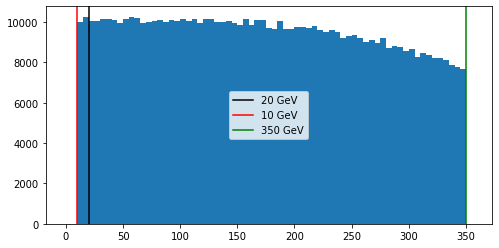

In [104]:
f=plt.figure(figsize=(8,4))
_=plt.hist(targetArr,bins=np.arange(0.0,360.0,5))
plt.axvline(20,color='k',label='20 GeV')
plt.axvline(10,color='r',label='10 GeV')
plt.axvline(350,color='g',label='350 GeV')
plt.legend(loc='center')

## Making the layerwise dataset

## Detector Layers

[]

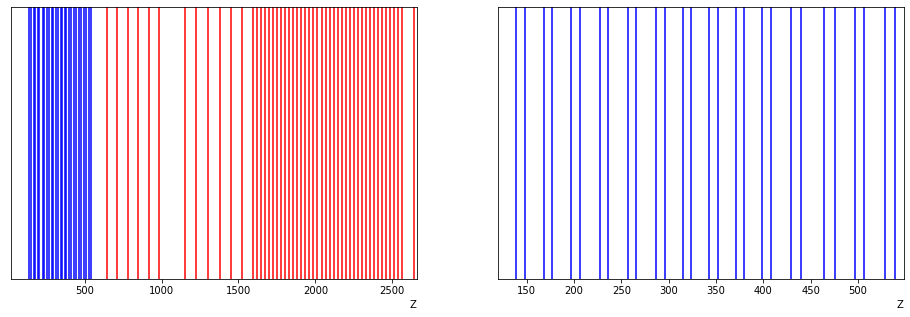

In [131]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
for z in detectorLayers['z'] :
    c='b'
    if z > 600:
        c='r'
    ax[0].axvline(z,color=c)
for z in detectorLayers['z'] :
    c='b'
    if z > 600:
        break
    ax[1].axvline(z,color=c)

ax[0].set_xlabel('Z',loc='right')
ax[0].set_yticks([])
ax[1].set_xlabel('Z',loc='right')
ax[1].set_yticks([])

## Event Discription

In [90]:
def plotEvent(events,idxs):
    f,ax=plt.subplots(1,2,figsize=(16,5))
    for z in detectorLayers['z'] :
        c='b'
        if z > 600:
            c='r'
        if z > 720:
            break
        ax[0].axvline(z,color=c,alpha=0.2)
    for idx in idxs:    
        ax[0].scatter(events['recHit_z'][idx],events['recHit_y'][idx],s=8,c='g')

        ax_cBar=f.add_axes([ax[1].get_position().x1+0.005,ax[1].get_position().y0,
                            0.01,ax[1].get_position().height])
        # ax_cBar.set_yticks([])
        cbar=ax[1].scatter(events['recHit_x'][idx],events['recHit_y'][idx],
                           s=10,c=events['recHit_z'][idx]*10,
                           cmap='cool',norm=matplotlib.colors.LogNorm(vmin=50,vmax=1000))
    
    ax[0].text(550,4,"$e^+$ Beam\n"+f"Energy : {events['target'][idx]:.2f} GeV",
               fontsize=12)
    cbar.set_label('Z')
    plt.colorbar(cbar,cax=ax_cBar)
    ax_cBar.set_ylabel('Z')

    ax[0].set_xlabel('Z',loc='right')
    ax[0].set_ylabel('Y',loc='top')

    ax[1].set_xlabel('X',loc='right')
    ax[1].set_ylabel('Y',loc='top')

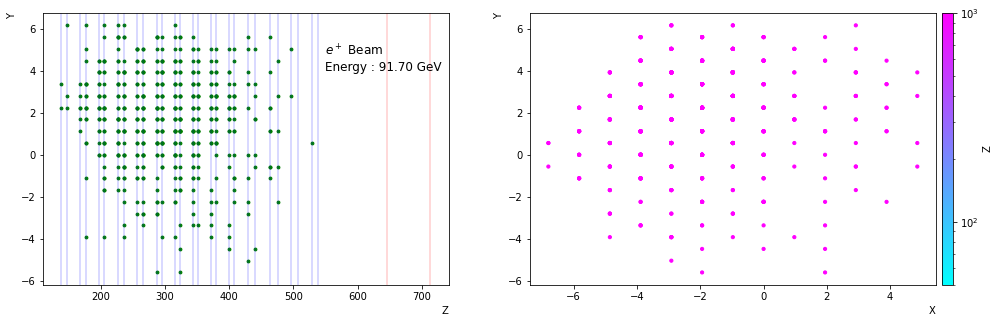

In [108]:
plotEvent(events,[10])

## LayerwiseSplit

In [112]:
layerZs=detectorLayers['z']
energySum={}
nHitsInLayer={}
N_LAYER_MAX=28
Emin=80
Emax=90
for i in range(1,N_LAYER_MAX+1):
    z_min=0.5*(layerZs[-1+i]+layerZs[i])
    z_max=0.5*(layerZs[i]+layerZs[1+i])
    print(f"\rprocessing the layer {i} at {layerZs[i]} [ {z_min:.3f} / {z_max:.3f} ] ",end="")
    layerMask= ( events['recHit_z'] >z_min) & ( events['recHit_z'] < z_max)
    energyMask = ( events['target'] > Emin ) & ( events['target'] < Emax)
    en_l=events['recHit_en'][energyMask][layerMask[energyMask]]
    energySum[i]=ak.sum(en_l,axis=1).to_numpy()
    nHitsInLayer[i]=ak.num(en_l).to_numpy()
    

processing the layer 28 at 646.185 [ 592.610 / 679.722 ] 

In [113]:
sum(energyMask)

617

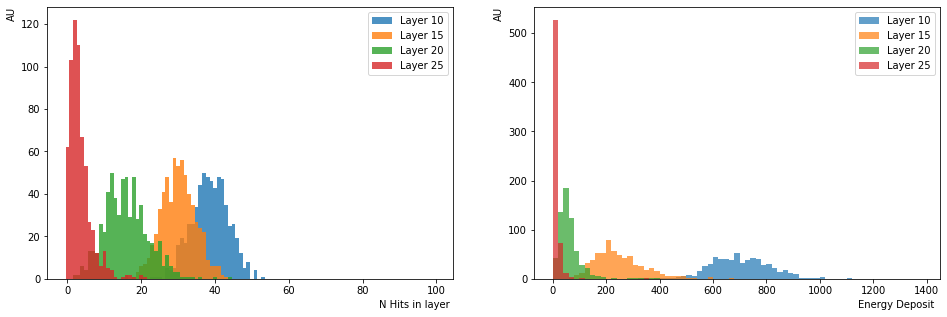

In [128]:
layerID=24
fig,ax=plt.subplots(1,2,figsize=(16,5))

for layerID in [10,15,20,25]:
    _=ax[0].hist(nHitsInLayer[layerID],bins=np.arange(-0.5,100.5,1),alpha=0.8,label = f"Layer {layerID}")
    _=ax[1].hist(energySum[layerID],alpha=0.7,label = f"Layer {layerID}",bins=np.arange(0.0,1400,20))

ax[0].set_xlabel(f'N Hits in layer ',loc='right')
ax[1].set_xlabel(f'Energy Deposit  ',loc='right')
ax[0].set_ylabel(f'AU',loc='top')
ax[1].set_ylabel(f'AU',loc='top')
ax[0].legend()
ax[1].legend()

## Export the data

In [133]:
nEventMax=int(len(f['nhits']))
Stride=int(5e4)
N_LAYER_MAX=28
layerZs= [detectorLayers['z'][0]-10.0] + detectorLayers['z']

energySumCollection={}
nHitsInLayerCollection={}
targetCollection={}

In [272]:
evtIdx=0
vars_Offset=0
while evtIdx < nEventMax:
    evtMin=evtIdx
    evtMax=min(evtMin+Stride,nEventMax)
    print(f"Processing the events between {evtMin} and {evtMax} ")
    nRecHits=np.array(f['nhits'][evtMin:evtMax],dtype=int)
    sumRecHits=np.sum(nRecHits)
    vars_OffsetHigh=vars_Offset+sumRecHits
    print(f"\tProcesing a total of {sumRecHits} recHits")
    events={
            'nRecHits'  : nRecHits,
            'target'    : f['target'][evtMin:evtMax],
            'recHit_en' : ak.unflatten(f['rechit_energy'][vars_Offset:vars_OffsetHigh],nRecHits),
            'recHit_x'  : ak.unflatten(f['rechit_x'][vars_Offset:vars_OffsetHigh] ,nRecHits),
            'recHit_y'  : ak.unflatten(f['rechit_y'][vars_Offset:vars_OffsetHigh] ,nRecHits),
            'recHit_z'  : ak.unflatten(f['rechit_z'][vars_Offset:vars_OffsetHigh] ,nRecHits)*10
        }
    energySum={}
    nHitsInLayer={}
    for i in range(1,N_LAYER_MAX+1):
        z_min=0.5*(layerZs[-1+i]+layerZs[i])
        z_max=0.5*(layerZs[i]+layerZs[1+i])
        print(f"\r\tprocessing the layer {i} at {layerZs[i]} [ {z_min:.3f} / {z_max:.3f} ] ",end="")
        layerMask= ( events['recHit_z'] >z_min) & ( events['recHit_z'] < z_max)
        en_l=events['recHit_en'][layerMask]
        energySum[i]=ak.sum(en_l,axis=1).to_numpy()
        nHitsInLayer[i]=ak.num(en_l).to_numpy()
    
    energySumCollection[evtMin]=energySum
    nHitsInLayerCollection[evtMin]=nHitsInLayer
    targetCollection[evtMin]=np.array(events['target'], copy=True)
    evtIdx+=Stride
    vars_Offset+=sumRecHits
    print()
    for ky in list(events.keys()):
        del events[ky]
#     break

Processing the events between 0 and 50000 
	Procesing a total of 39965823 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 50000 and 100000 
	Procesing a total of 39998420 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 100000 and 150000 
	Procesing a total of 39998461 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 150000 and 200000 
	Procesing a total of 39934322 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 200000 and 250000 
	Procesing a total of 40009616 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 250000 and 300000 
	Procesing a total of 39927675 recHits
	processing the layer 28 at 539.035 [ 533.925 / 592.610 ] 
Processing the events between 300000 and 350000 
	Procesing a total of 39996797 recHits
	processing the layer 28 at 539.035 [

In [270]:
layerID=12
y=np.concatenate([ energySumCollection[ky][layerID] for ky in energySumCollection]  )

In [277]:
dataStore={}
for layer in range(1,28+1):
    dataStore[f'en_l{layer}']=np.concatenate([ energySumCollection[ky][layer] for ky in energySumCollection]  )
dataStore['target']=np.concatenate( [targetCollection[ky] for ky in targetCollection] )    

In [285]:
esum=np.sum([ dataStore[f'en_l{layer}']  for layer in range(1,28+1) ],axis=0)

## Energy Sum vs Target

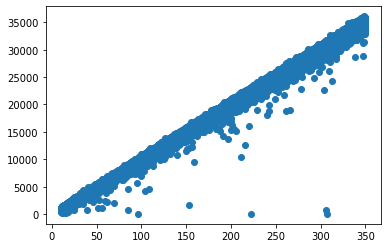

In [288]:
plt.scatter(dataStore['target'],esum)

In [291]:
dataStoreToTrain={}
dataStoreToTest={}
testFraction=0.2
for ky in dataStore:
    nTest=int(len(dataStore[ky])*testFraction)
    dataStoreToTest[ky]=dataStore[ky][:nTest]
    dataStoreToTrain[ky]=dataStore[ky][nTest:]

In [295]:
exportTree(dataStoreToTrain,'regressionTree','../workarea/hgcal_electron_data_0001_train.root')
exportTree(dataStoreToTest,'regressionTree','../workarea/hgcal_electron_data_0001_test.root')


	  file exported  :  ../workarea/hgcal_electron_data_0001_train.root

	  file exported  :  ../workarea/hgcal_electron_data_0001_test.root


In [309]:
oFile=h5py.File('../workarea/hgcal_electron_data_0001_train.h5','w')

for ky in dataStoreToTrain:
    oFile.create_dataset(ky,data=dataStoreToTrain[ky])

oFile.attrs.update(detectorLayers)

oFile.close()

In [313]:
oFile=h5py.File('../workarea/hgcal_electron_data_0001_test.h5','w')
for ky in dataStoreToTest:
    oFile.create_dataset(ky,data=dataStoreToTest[ky])
oFile.attrs.update(detectorLayers)
oFile.close()